<strong><b><font size="5">Análise Estatística e Modelagem Preditiva de Séries Temporais - Em Python</font></b></strong>

<strong><b><font size="5">Projeto Final do Curso - Parte 3</font></b></strong>

<strong><b><font size="4">Qual o Efeito da Legalização da Maconha na Taxa de Criminalidade ao Longo do Tempo?</font></b></strong>

Começaremos agora a Parte 3. Usaremos os 4 arquivos csv gerados na Parte 2:

- df_crimes.csv
- df_escolas.csv
- df_lojas.csv
- df_prisoes_parte2.csv

O que faremos na Parte 3:

- Modelage Preditiva
- Análise de Séries Temporais
- Conclusões Finais

### Carregando os Pacotes Usados Neste Jupyter Notebook

In [1]:
# As novas versões do Pandas e Matplotlib trazem diversas mensagens de aviso ao desenvolvedor. Vamos desativar isso.
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação e visualização de dados
import math
import numpy as np
import pandas as pd
import matplotlib as m
import matplotlib.pyplot as plt
from scipy import stats

# Imports para Machine Learning
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

# Imports para Análise de Séries Temporais
import pickle
import calendar
import statsmodels
from statsmodels.tsa.arima_model import ARIMA, ARMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.stattools import acf, pacf

# Imports para formatação dos gráficos
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 15,7
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark --iversions

pandas      1.0.4
statsmodels 0.11.1
numpy       1.18.4
sklearn     0.23.1
matplotlib  3.2.1



## Modelagem Preditiva

Vamos iniciar nosso trabalho criando um modelo de Machine Learning para classificação e compreendendo quais são as variáveis mais relevantes para prever a ocorrência de prisões.

In [3]:
# Carregando os dados de prisões
df_prisoes = pd.read_csv('dados/df_prisoes_parte2.csv')

In [4]:
# Shape
df_prisoes.shape

(6226, 14)

In [5]:
# Dados
df_prisoes.head()

,Arrest Date,Time,Area Name,Age,Sex Code,Descent Code,Arrest Type Code,Charge Description,latitude,longitude,loja_0.5_milha,loja_1_milha,escola_0.5_milha,escola_1_milha
0,2019-03-09,2015.0,Hollywood,29,M,O,F,possession marijuana for sale,34.1016,-118.3350,7,8,2,5
1,2019-03-09,2015.0,Hollywood,25,M,B,F,possession marijuana for sale,34.1016,-118.3350,7,8,2,5
2,2019-04-21,2115.0,Wilshire,42,M,B,F,poss/sale marij ovr 21 employ per 20/belw,34.0838,-118.3614,4,13,4,8
3,2019-05-01,1045.0,Pacific,26,M,B,F,sale/trans >28.5g marijuana or >4g,33.9428,-118.4054,0,0,0,0
4,2019-05-01,5.0,N Hollywood,27,M,B,F,sale/trans >28.5g marijuana or >4g,34.1667,-118.3965,0,1,3,4


In [6]:
# Criamos uma lista de razões para as prisões
charge_description_list = list(df_prisoes['Charge Description'].unique())

In [9]:
# Ordenamos a lista
charge_description_list.sort()
charge_description_list

['attempt - sell/furnish/etc marijuana',
 'cultivate >6 marij plants viol envrnt law',
 'cultivating <6 marijuana plants',
 'furnishing marijuana to minor over 14 yrs',
 'give/transport/etc < 28.5 grams marijuana',
 'induce/etc minor to use/sell marijuana',
 'minor poss 28.5+ grams marijuana/school',
 'minor poss < 28.5 grams marijuana/school',
 'poss for sale of marijuana to a minor',
 'poss marijuana or concentrated cannabis',
 'poss of more than 28.5 grams of marijuana',
 'poss open cont/packg marij drivr/passnger',
 'poss/sale marij ovr 21 employ per 20/belw',
 'poss/smoke/ingest marij school/daycare/yc',
 'possess 28.5 grams or less of marijuana',
 'possess 28.5 grams or less of marijuana**',
 'possess marijuana for sale',
 'possess marijuana for sale under age 18',
 'possess of marijuana while driving veh',
 'possession marijuana for sale',
 'possession of marijuana in school',
 'sale/offer to sell/transport marijuana',
 'sale/trans >28.5g marijuana or >4g',
 'sale/transport mari

Agora criaremos nossa variável target.

A variavél target será classificado como venda ou não de maconha baseado nos motivos de prisões.
Se no motivo existir a palava "sale" iremos classificar o motivo como venda.

In [59]:
# Aplicamos função map para identificar venda de maconha
target = df_prisoes['Charge Description'].map(lambda x: 1 if ('sale' in x or 'sell' in x) else 0)

In [60]:
# Contamos os registros de cada classe e mostramos como proporção percentual
# 1 - venda de maconha
# 0 - Não venda
target.value_counts(normalize = True)

1    0.616929
0    0.383071
Name: Charge Description, dtype: float64

Como as classes são um pouco desequilibradas, vamos estratificá-las para que haja a mesma proporção de observações de 'venda' e 'não venda' nos conjuntos de dados de treino e teste, mais a frente.

In [61]:
# Inclui a variável no dataframe
df_prisoes['target'] = target

In [63]:
# Dados
df_prisoes.head()

,Arrest Date,Time,Area Name,Age,Sex Code,Descent Code,Arrest Type Code,Charge Description,latitude,longitude,loja_0.5_milha,loja_1_milha,escola_0.5_milha,escola_1_milha,target
0,2019-03-09,2015.0,Hollywood,29,M,O,F,possession marijuana for sale,34.1016,-118.3350,7,8,2,5,1
1,2019-03-09,2015.0,Hollywood,25,M,B,F,possession marijuana for sale,34.1016,-118.3350,7,8,2,5,1
2,2019-04-21,2115.0,Wilshire,42,M,B,F,poss/sale marij ovr 21 employ per 20/belw,34.0838,-118.3614,4,13,4,8,1
3,2019-05-01,1045.0,Pacific,26,M,B,F,sale/trans >28.5g marijuana or >4g,33.9428,-118.4054,0,0,0,0,1
4,2019-05-01,5.0,N Hollywood,27,M,B,F,sale/trans >28.5g marijuana or >4g,34.1667,-118.3965,0,1,3,4,1


Variável target incluída. Vamos checar algumas correlações.

In [17]:
# Correlação entre as variáves de distância do ponto de venda
df_prisoes[['loja_0.5_milha', 'loja_1_milha']].corr()

,loja_0.5_milha,loja_1_milha
loja_0.5_milha,1.000000,0.825199
loja_1_milha,0.825199,1.000000


In [18]:
# Correlação entre as variáves de distância da escola
df_prisoes[['escola_0.5_milha', 'escola_1_milha']].corr()

,escola_0.5_milha,escola_1_milha
escola_0.5_milha,1.000000,0.777587
escola_1_milha,0.777587,1.000000


As variáveis estão altamente correlacionadas e isso é ruim para o modelo. Precisamos remover uma variável de cada par que avaliamos.

In [64]:
# Remove variáveis que posssuem correlação (loja 0.5 e escola 0.5), permanecendo somente as a 1 milha de distancia. 
# O restante das variáveis estarão no dataset X que serão nossas variáives independentes.
X = df_prisoes.drop(['loja_0.5_milha', 'escola_0.5_milha'], 1)

In [66]:
# Vamos remover as variáveis de data, motivo da prisão e target do nosso dataset X
X = X.drop(['Arrest Date', 'Charge Description', 'target'],1)

In [69]:
# Criamos variáveis dummy para as variáveis categóricas, pois assim trabalhamos apenas com variáveis numéricas.
# Na criação de variáveis dummy, todas as possibilidade de valores das variáveis categóricas se tornaram uma coluna no dataset
# que são preenchidos com valores binários {0.1}
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html
X = pd.get_dummies(X)

In [70]:
# Dados
X.head()

,Time,Age,latitude,longitude,loja_1_milha,escola_1_milha,Area Name_77th Street,Area Name_Central,Area Name_Devonshire,Area Name_Foothill,...,Descent Code_F,Descent Code_G,Descent Code_H,Descent Code_O,Descent Code_P,Descent Code_W,Descent Code_X,Arrest Type Code_F,Arrest Type Code_I,Arrest Type Code_M
0,2015.0,29,34.1016,-118.3350,8,5,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1,2015.0,25,34.1016,-118.3350,8,5,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,2115.0,42,34.0838,-118.3614,13,8,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1045.0,26,33.9428,-118.4054,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,5.0,27,34.1667,-118.3965,1,4,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [71]:
# Colocando a variável target em uma variável isolada
y = df_prisoes['target']

In [72]:
# Dados
y.head()

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64

In [75]:
# Divisão em dados de treino e teste
# Devido ao desbalanceamento dos dados como observamos anteriormente 61% dos dados são motivos de venda de maconha e 39% não venda
# Utilizamos o parâmetro stratify para garantir que teremos 61% de dados de uma classe e 39% de outra classe.
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, random_state = 42, stratify = y, test_size = 0.25)

In [76]:
# Cria o modelo de regressão logistica, utilizado para problemas de classificação
modelo_lr = LogisticRegression()

In [77]:
# Treinamento do modelo
modelo_lr.fit(X_treino, y_treino)

LogisticRegression()

In [78]:
# Avalia a acurácia nos dados de treino
acc_treino = modelo_lr.score(X_treino, y_treino)
print(f'Acurácia em Treino: {round(acc_treino, 2) * 100}')

Acurácia em Treino: 87.0


In [79]:
# Avalia a acurácia em teste
acc_teste = modelo_lr.score(X_teste, y_teste)
print(f'Acurácia em Teste: {round(acc_teste, 2) * 100}')

Acurácia em Teste: 89.0


Estamos com boa acurácia. Vamos extrair os coeficientes e realizar mais algumas análises.

In [80]:
# Coeficientes beta de cada variável do modelo
beta = modelo_lr.coef_[0]

In [83]:
# Atributos (Variáveis do dataset)
atributos = list(X.columns)

In [85]:
# Criamos um dataframe associando os coeficientes aos atributos e ajustamos o índice
beta_df = pd.DataFrame({'atributos': atributos, 'beta' :beta})
beta_df.set_index('atributos', inplace = True)

In [86]:
# Dados
beta_df.head()

,beta
atributos,
Time,-0.000258
Age,-0.032401
latitude,-0.235090
longitude,-0.079885
loja_1_milha,-0.018671


In [87]:
# Vamos extrair o Log ODD
beta_df['log_odds'] = beta_df['beta'].map(lambda x: np.exp(x))

In [88]:
# Ordenamos os dados
beta_df = beta_df.sort_values('log_odds', ascending = False)

In [89]:
# Dados
beta_df.head(10)

,beta,log_odds
atributos,,
Arrest Type Code_F,2.703069,14.925464
Descent Code_B,0.619410,1.857831
Area Name_Southeast,0.489421,1.631371
Area Name_Pacific,0.343590,1.410001
Sex Code_F,0.151044,1.163048
Area Name_Central,0.129792,1.138591
Area Name_77th Street,0.127493,1.135977
Area Name_Harbor,0.117278,1.124432
Area Name_Southwest,0.055373,1.056935


Todas as variáveis são relevantes para a previsão de prisão por venda de maconha.

In [90]:
# Vamos verificar os registros de escolas a 1 milha de distância
beta_df[beta_df.index == 'escola_1_milha']

,beta,log_odds
atributos,,
escola_1_milha,-0.027594,0.972784


O modelo de Regressão Logística permite extrair não apenas previsões de classe, mas também as probabilidades. Vejamos que análises podemos fazer com isso.

In [102]:
# O resultado da previsão em probabilidade é relacionado as 2 categorias que temos:
# 0 > Não venda
# 1 > Venda Maconha

# O primeiro valor do array representa a categoria 0, e o segundo o 1.
# Analisando o primeiro registro, temos 85% de probabilidade de não ser uma prisão relacionada a venda de maconha e
# 15% de probabilidade de ter sido uma prisão relacionado a venda de maconha.
modelo_lr.predict_proba(X_teste)

array([[0.84526881, 0.15473119],
       [0.09730133, 0.90269867],
       [0.05331647, 0.94668353],
       ...,
       [0.08074155, 0.91925845],
       [0.04145938, 0.95854062],
       [0.09492145, 0.90507855]])

In [91]:
# Probabilidades da prisão por venda de maconha (classe target = 1)
prob_prisao_venda = modelo_lr.predict_proba(X_teste)[:,1]

In [103]:
# Probabilidades de ter sido uma prisão decorrente da venda de maconha.
prob_prisao_venda

array([0.15473119, 0.90269867, 0.94668353, ..., 0.91925845, 0.95854062,
       0.90507855])

In [104]:
# Cria um dataframe com valores reais de teste e probabilidades previstas pelo modelo.
pred_df = pd.DataFrame({'valores_reais': y_teste, 'valores_previstos':prob_prisao_venda})

In [109]:
pred_df

,valores_reais,valores_previstos
1780,0,0.154731
2379,0,0.902699
3731,1,0.946684
6068,1,0.910203
4958,1,0.939790
...,...,...
1932,0,0.110623
414,0,0.116016
5487,1,0.919258
2752,0,0.958541


Um gráfico irá facilitar a análise e compreensão.

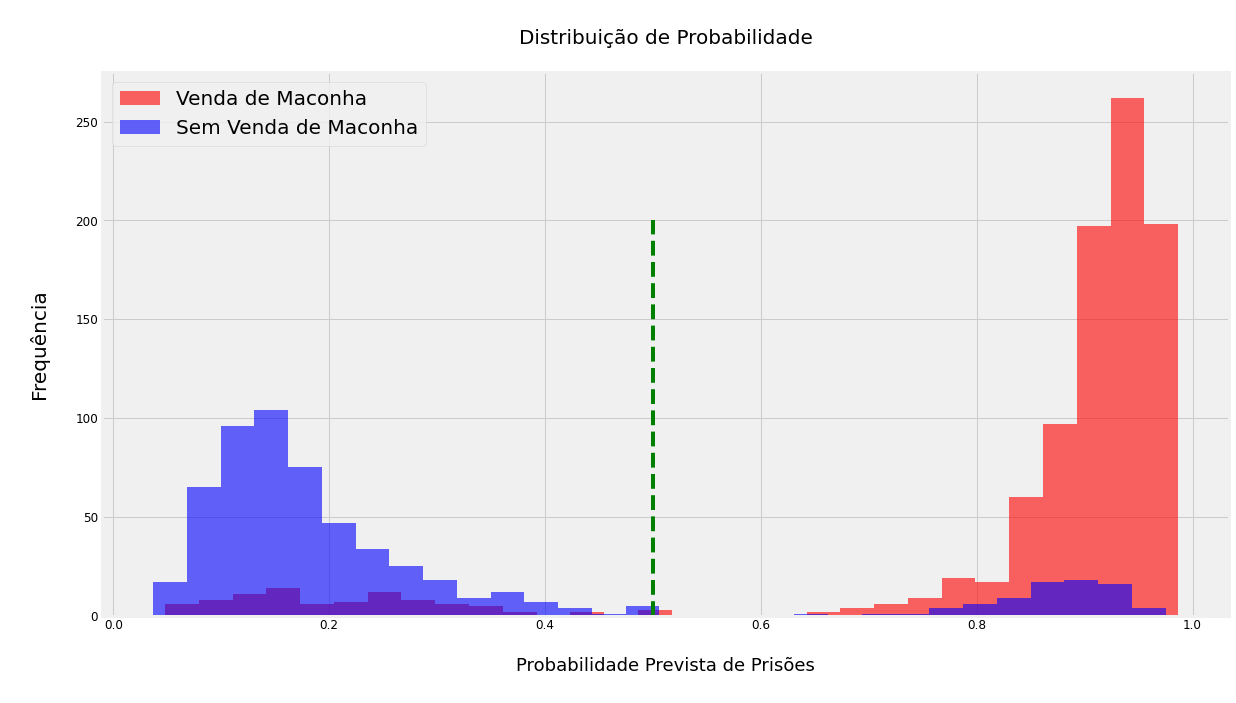

In [133]:
# Plot da Distribuição de Probabilidades

# Figura
plt.figure(figsize = (18,10))

# Histograma dos valores reais x valores previstos para a classe 1
plt.hist(pred_df[pred_df['valores_reais'] == 1]['valores_previstos'], 
         bins = 30, 
         color = 'r', 
         alpha = 0.6, 
         label = 'Venda de Maconha')

# Histograma dos valores reais x valores previstos para a classe 0
plt.hist(pred_df[pred_df['valores_reais'] == 0]['valores_previstos'],
         bins = 30,
         color = 'blue',
         alpha = 0.6,
         label = 'Sem Venda de Maconha')

# Linha central do gráfico - vline - vertical line
plt.vlines(x = 0.5, ymin = 0, ymax = 200, color = 'green', linestyle = '--')

# Labels e Legenda
plt.title('\nDistribuição de Probabilidade\n', fontsize = 20)
plt.ylabel('\nFrequência\n', fontsize = 20)
plt.xlabel('\nProbabilidade Prevista de Prisões\n', fontsize = 18)
plt.legend(fontsize = 20);

Realizando a análise visual, é possível identificar que o modelo preditivo criado foi capaz de classificar com uma probabilidade boa, perfils de vendedores de maconha ilegal.

Será que a proximidade de um Departamento de Polícia altera o resultado? Vamos analisar.

In [134]:
# Extrai os coeficientes por nome da área
beta_df = beta_df[beta_df.index.str.contains('Area Name')].head(8)

In [135]:
# Dados
beta_df.head()

,beta,log_odds
atributos,,
Area Name_Southeast,0.489421,1.631371
Area Name_Pacific,0.343590,1.410001
Area Name_Central,0.129792,1.138591
Area Name_77th Street,0.127493,1.135977
Area Name_Harbor,0.117278,1.124432


Os Departamentos de Polícia na cidade de Los Angeles estão registrados aqui:
    
http://www.lapdonline.org/our_communities/content_basic_view/6279 
   
Precisamos das coordenadas para os gráficos.

Essa coleta poderia ter sido feita utilizando web scrapping.

In [136]:
# Latitude dos Departamentos de Polícia na cidade de Los Angeles
beta_df['latitude'] = [33.9383761,
                       34.097986,
                       33.9920067,
                       34.0443028,
                       33.7584097,
                       34.050264,
                       34.1195162,
                       34.1842023]

In [137]:
# Longitude dos Departamentos de Polícia na cidade de Los Angeles
beta_df['longitude'] = [-118.2749244,
                        -118.331013,
                        -118.4199295,
                        -118.4509833,
                        -118.2880336,
                        -118.291531,
                        -118.2497385,
                        -118.3021552]

In [145]:
beta_df

,beta,log_odds,latitude,longitude
atributos,,,,
Area Name_Southeast,0.489421,1.631371,33.938376,-118.274924
Area Name_Pacific,0.343590,1.410001,34.097986,-118.331013
Area Name_Central,0.129792,1.138591,33.992007,-118.419929
Area Name_77th Street,0.127493,1.135977,34.044303,-118.450983
Area Name_Harbor,0.117278,1.124432,33.758410,-118.288034
Area Name_Southwest,0.055373,1.056935,34.050264,-118.291531
Area Name_Hollywood,0.028771,1.029189,34.119516,-118.249739
Area Name_Olympic,0.015638,1.015761,34.184202,-118.302155


Criamos o Plot.

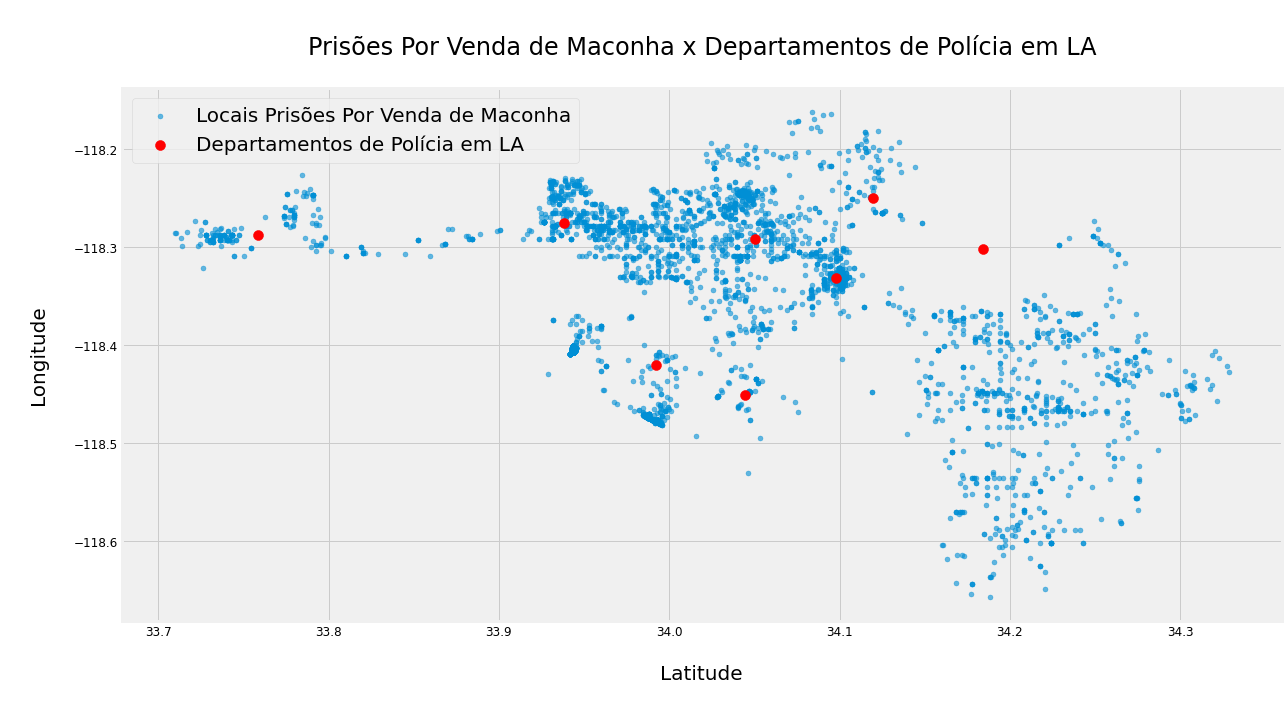

In [149]:
# Plot da classe 1 (prisão por motivo de venda de maconha ilegal) com principais atributos versus Depart Policia

# Figura
fig, ax = plt.subplots(figsize = (18,10))

# Plot
plt.scatter(df_prisoes[df_prisoes['target'] == 1]['latitude'], 
            df_prisoes[df_prisoes['target'] == 1]['longitude'], 
            s = 25, 
            alpha = 0.6,
            label = 'Locais Prisões Por Venda de Maconha')

ax.scatter(beta_df['latitude'], 
           beta_df['longitude'], 
           color = 'red', 
           label = 'Departamentos de Polícia em LA', 
           s = 100)

# Títulos, labels e legenda
plt.title('\nPrisões Por Venda de Maconha x Departamentos de Polícia em LA\n', fontsize = 24)
plt.xlabel('\nLatitude\n', fontsize = 20)
plt.ylabel('\nLongitude\n', fontsize = 20)
ax.legend(fontsize = 20)
plt.tight_layout()

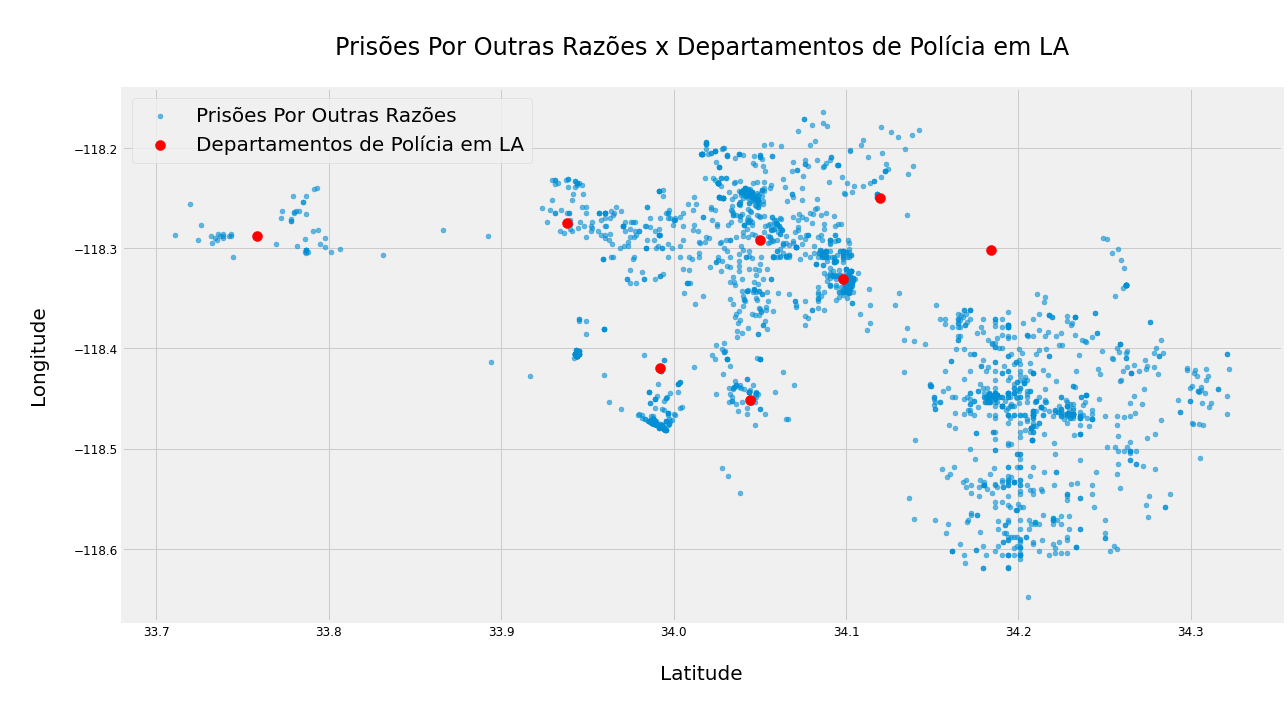

In [152]:
# Plot da classe 0 com principais atributos versus prisões por maconha

# Figura
fig, ax = plt.subplots(figsize = (18,10))

# Plot
plt.scatter(df_prisoes[df_prisoes['target'] ==0]['latitude'], 
            df_prisoes[df_prisoes['target'] ==0]['longitude'], 
            s = 25, 
            alpha = 0.6,
            label = 'Prisões Por Outras Razões')

ax.scatter(beta_df['latitude'], 
           beta_df['longitude'], 
           color = 'red', 
           label = 'Departamentos de Polícia em LA', 
           s = 100)

# Títulos, labels e legenda
plt.title('\nPrisões Por Outras Razões x Departamentos de Polícia em LA\n', fontsize = 24)
plt.xlabel('\nLatitude\n', fontsize = 20)
plt.ylabel('\nLongitude\n', fontsize = 20)
ax.legend(fontsize = 20)
plt.tight_layout()

# Resultado Análise:



- O modelo criado foi capaz de obter excelentes resultados durante o treinamento e durante a etapa de teste, conseguindo atingir >85% de acurácia em ambos os casos. Baseado nesse fator é válido afirmar que existe um padrão entre as pessoas que vendem maconha de forma ilegal, pois o modelo foi capaz de identificar esse padrão.


- A localização de prisões relacionadas a venda de maconha e outros motivos de prisões ocorrem por todo o estado.


- O total de prisões relacionado à maconha vem caindo desde 2014, mas no ano de 2017 quando foi legalizado a venda da maconha, houve uma queda brusca no número de prisões relacionadas à maconha.


- Não houve aumento de criminalidade em locais próximos a pontos de venda. Para uma resposta mais precisa referente a esse ponto, seria necessário informações de data que as lojas surgiram, assim poderia ser aplicado uma análise cruzando volume de crimes x volume de lojas no tempo.


- No gráfico 'prisões x Pontos de Vendas' é possível notar claramente a diminuição da taxa de criminalidade no ano de 2017 para 2018. Vale lembrar que em 2017 o número de pontos de venda legalizado é inferior ao ano de 2018. Os dados aqui apresentados de pontos de vendas se referem a quantidade atual de pontos de vendas.


- Houve uma queda brusca no número de prisões próximos à escolas em até 1 minha de distância a partir do ano de 2017 (após a legalização da maconha).


- A proximidade das prisões com pontos de vendas ou com escolas não parece variar de um ano para o outro, o que leva a crer que pontos de venda ou escolas não estão ligados às prisões. Logo, podemos levantar como hipótese que não ocorreu o cultivo de maconha próximo a escolas.


- A variável **escola_1_milha** é a contagem de escolas que estão dentro de 1 milha de cada prisão efetuada. Devido às chances de log de 'escola_1_milha', ter uma escola a menos de 1,6 km de uma prisão é tão provável quanto a prisão por maconha estar relacionada à venda e a não venda.


- Em relação as prisões por tipo de crime, desde 2014 o TOP 5 vem sofrendo alterações e não possui um padrão de prisões rankeado. Os motivos podem ter sofrido alteração pois a lei mudou.


- Existem duas classes: vender maconha e não vender maconha, e argumenta-se que a venda de maconha expõe mais crianças à maconha, porém o cigarro também e ninguém fala nada.


Aplico como resultado final da minha análise, baseado nos dados aqui obtidos e no cenário aqui exposto, que **NÃO existe relação entre Legalização da Maconho e Aumento da Taxa de Criminalidade ao longo do tempo na cidade Los Angeles**.

E Você, É favor ou contra à legalização da Maconha?